In [ ]:
# !pip install pmdarima
# !pip install numpy==1.26.4

In [ ]:
def model_assessment(train, test, predictions, chart_title=None):
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(predictions.index, predictions, label='Predictions', color='green')
    plt.title(chart_title)
    plt.legend()
    plt.show()

    # Calculate and print RMSE, MAE, MAPE
    rmse = root_mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)

    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {100*mape:.2f}%")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima import auto_arima, ARIMA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
file_path = 'https://raw.githubusercontent.com/thethien8a/Forecasting/refs/heads/main/study-2/course-material/Time%20Series%20Analysis/ARIMA%2C%20SARIMA%20and%20SARIMAX/daily_revenue.csv'

In [ ]:
df = pd.read_csv(f"{file_path}", parse_dates=['date'], index_col='date', dayfirst=True)
# df.index.freq = 'W-MON'  # Đặt tần suất cho index để tránh cảnh báo ValueWarning
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


In [ ]:
df["revenue"] = df["revenue"].str.replace(',', '').astype(float)

In [ ]:
## Setting the Frequency
df = df.asfreq("D")

In [ ]:
# Change the name of the time series variable to y
df = df.rename(columns={'revenue': 'y'})
df.head()

,y,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%
2018-01-03,8446101.0,28.11%,1.01%
2018-01-04,7785798.0,27.32%,0.96%
2018-01-05,6375303.0,25.70%,0.90%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Freq: D
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              1795 non-null   float64
 1   discount_rate  1795 non-null   object 
 2   coupon_rate    1795 non-null   object 
dtypes: float64(1), object(2)
memory usage: 56.1+ KB


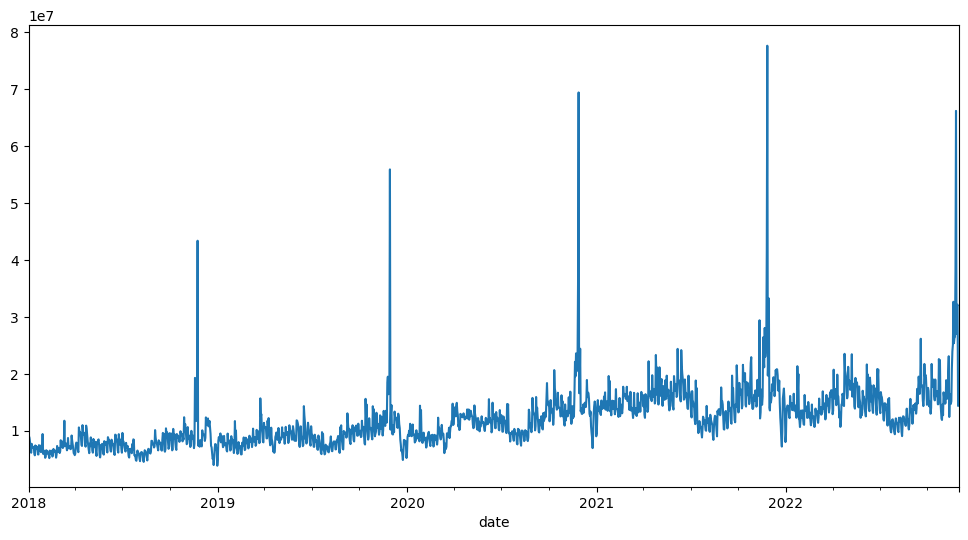

In [ ]:
# Time series plot
df["y"].plot(figsize=(12, 6));

In [ ]:
# month_plot(df['y'].resample('ME').mean());.

In [ ]:
# quarter_plot(df['y'].resample('QE').mean());

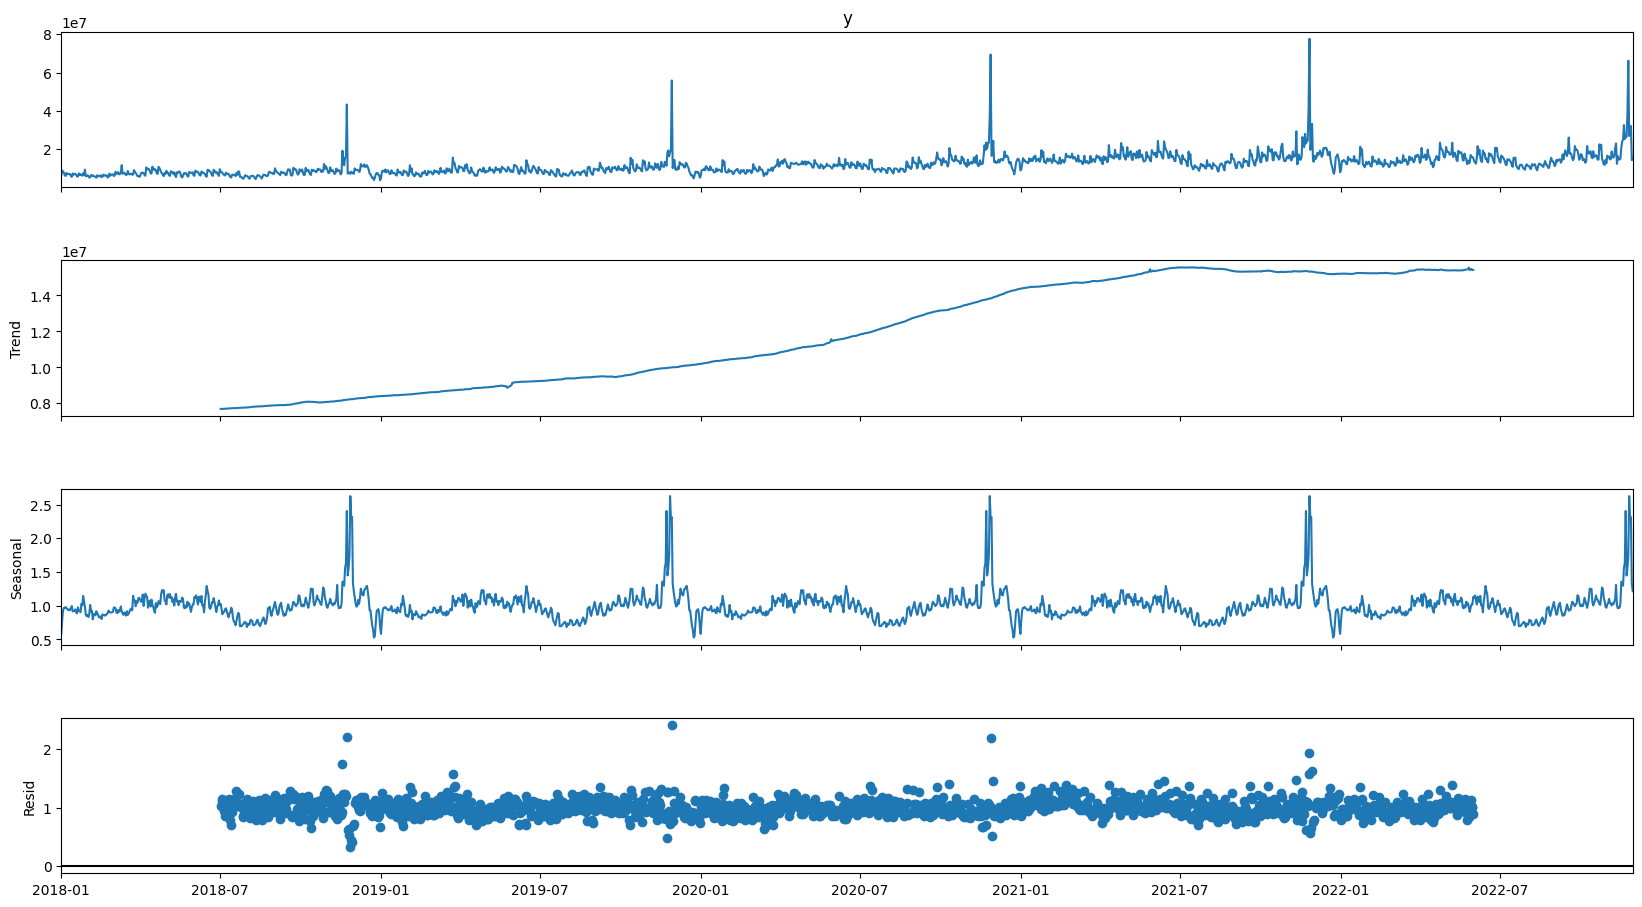

In [ ]:
# Seasonal decomposition for Revenue
decomposition = seasonal_decompose(df["y"], model='mul',period=365)
fig = decomposition.plot()
fig.set_size_inches(18,10)
plt.show()

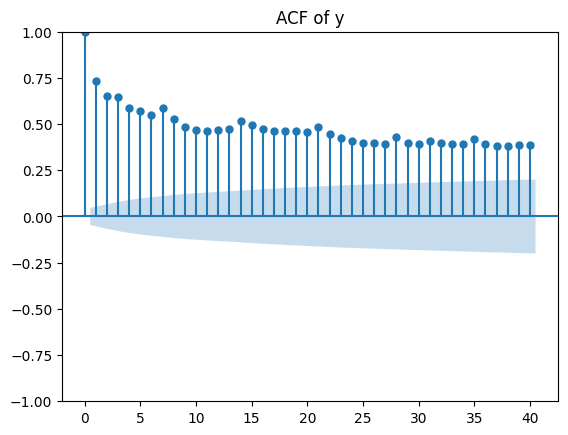

In [ ]:
# import acf và pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['y'], lags=40, title='ACF of y');

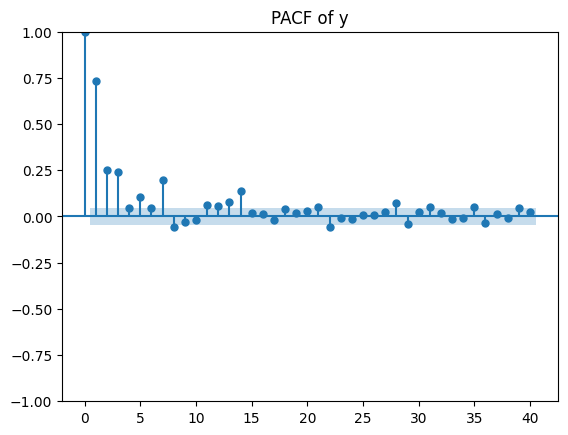

In [ ]:
plot_pacf(df['y'], lags=40, title='PACF of y');

### Stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Used lag:", result[2])
    print("Number of observations:", result[3])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    if result[1] < 0.05:
        print("=> Chuỗi là dừng (stationary)")
    else:
        print("=> Chuỗi KHÔNG dừng (non-stationary)")

# Kiểm tra stationarity cho
check_stationarity(df['y'])

ADF Statistic: -2.558399532351392
p-value: 0.10190360862386139
Used lag: 21
Number of observations: 1773
Critical Values:
   1%: -3.4340
   5%: -2.8632
   10%: -2.5676
=> Chuỗi KHÔNG dừng (non-stationary)


In [ ]:
df["y_diff"] = df.y.diff().dropna()
df["y_diff"].head()

,y_diff
date,
2018-01-01,NaN
2018-01-02,2651237.0
2018-01-03,-475975.0
2018-01-04,-660303.0
2018-01-05,-1410495.0


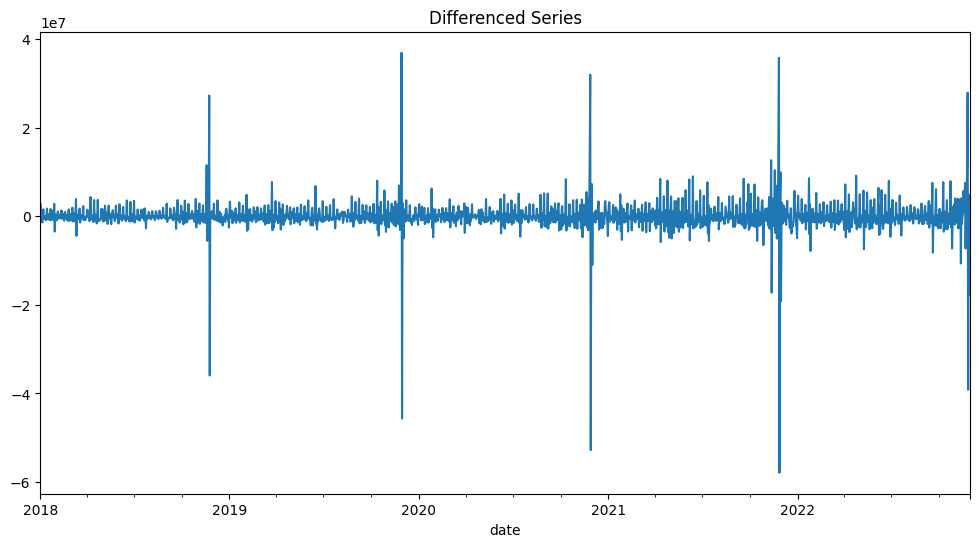

In [ ]:
df["y_diff"].plot(figsize=(12, 6), title='Differenced Series');

In [ ]:
check_stationarity(df['y_diff'])

ADF Statistic: -12.808786916716016
p-value: 6.513792026815736e-24
Used lag: 20
Number of observations: 1773
Critical Values:
   1%: -3.4340
   5%: -2.8632
   10%: -2.5676
=> Chuỗi là dừng (stationary)


In [ ]:
# Split the Daata into train and test
test_days = 30
train,test = df.iloc[:-test_days], df.iloc[-test_days:]

In [ ]:
# Finding best parameter for ARIMA with pmdarima
model = auto_arima(train['y'], seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28817.267
Date:                Fri, 15 Aug 2025   AIC                          57650.535
Time:                        04:43:05   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.000       0.103       0.211
ar.L4          0.0679      0.029      2.365      0.018       0.012       0.124
ar.L5          0.0466      0.024      1.937      0.053      -0.001       0.094
ma.L1         -0.1598      0.118     -1.354      0.176      -0.391       0.071
ma.L2         -0.7423      0.108     -6.872      0.000      -0.954      -0.531
sigma2      9.084e+12   1.86e-14   4.88e+26      0.000    9.08e+12    9.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            580903.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             5.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.93e+42. Standard errors may be unstable.
"""

In [ ]:
# Predictions
predictions_arima = model.predict(n_periods=test_days)
predictions_arima

,0
2022-11-01,1.445299e+07
2022-11-02,1.474103e+07
2022-11-03,1.503283e+07
2022-11-04,1.527520e+07
2022-11-05,1.534078e+07
2022-11-06,1.553442e+07
2022-11-07,1.554542e+07
2022-11-08,1.563967e+07
2022-11-09,1.565016e+07
2022-11-10,1.569221e+07


### SARIMA(p,d,q)(P,D,Q)m
- p,d,q = non-seasonal components
- P,D,Q = seasonal components
- m = number of periods in each season

In [ ]:
# Using pmdarima for the sarima model and the best parameters
model_sarima = auto_arima(train['y'],
                          seasonal=True,
                          m=7,
                          n_jobs=-1)
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28762.051
Date:                           Fri, 15 Aug 2025   AIC                          57546.103
Time:                                   04:45:57   BIC                          57606.331
Sample:                               01-01-2018   HQIC                         57568.358
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.007e+04   4683.100      2.150      0.032     889.611    1.92e+04
ar.L1         -0.3476      0.072     -4.798      0.000      -0.490      -0.206
ar.L2          0.1856      0.032      5.722      0.000       0.122       0.249
ar.L3          0.1034      0.016      6.523      0.000       0.072       0.135
ma.L1         -0.1958      0.074     -2.656      0.008      -0.340      -0.051
ma.L2         -0.5684      0.060     -9.401      0.000      -0.687      -0.450
ar.S.L7        0.0805      0.181      0.445      0.656      -0.274       0.435
ar.S.L14       0.8712      0.172      5.070      0.000       0.534       1.208
ma.S.L7       -0.0035      0.176     -0.020      0.984      -0.349       0.342
ma.S.L14      -0.8322      0.157     -5.310      0.000      -1.139      -0.525
sigma2      9.294e+12      0.000   8.85e+16      0.000    9.29e+12    9.29e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            848627.06
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             5.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.73e+32. Standard errors may be unstable.
"""

In [ ]:
# Predictions
predictions_sarima = model_sarima.predict(n_periods=test_days)
predictions_sarima

,0
2022-11-01,1.513413e+07
2022-11-02,1.504531e+07
2022-11-03,1.464456e+07
2022-11-04,1.382187e+07
2022-11-05,1.398001e+07
2022-11-06,1.697839e+07
2022-11-07,1.583294e+07
2022-11-08,1.605196e+07
2022-11-09,1.575787e+07
2022-11-10,1.523577e+07


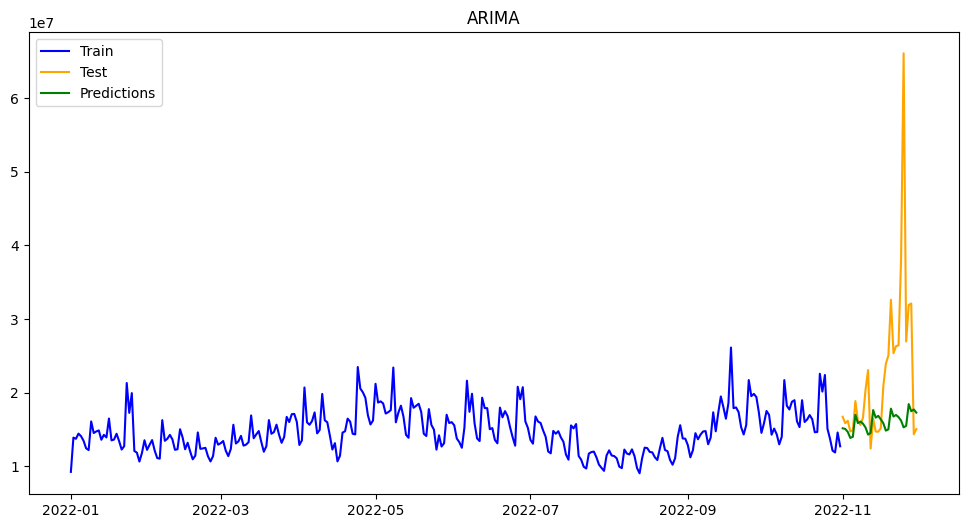

RMSE: 12152435.24
MAE: 7210580.53
MAPE: 24.54%


In [ ]:
model_assessment(train['y']['2022'], test['y']['2022'], predictions_sarima, chart_title='ARIMA')

### SARIMAX (Consider external impact)

In [ ]:
df.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2018-01-01,6270839.0,34.27,1.09,NaN
2018-01-02,8922076.0,30.87,1.08,2651237.0
2018-01-03,8446101.0,28.11,1.01,-475975.0
2018-01-04,7785798.0,27.32,0.96,-660303.0
2018-01-05,6375303.0,25.70,0.90,-1410495.0


In [ ]:
# Transform coupon_rate and discount_rate to float
df["discount_rate"] = df["discount_rate"].str.replace("%", "").astype(float)
df["coupon_rate"] = df["coupon_rate"].str.replace("%", "").astype(float)

In [ ]:
df.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2018-01-01,6270839.0,34.27,1.09,NaN
2018-01-02,8922076.0,30.87,1.08,2651237.0
2018-01-03,8446101.0,28.11,1.01,-475975.0
2018-01-04,7785798.0,27.32,0.96,-660303.0
2018-01-05,6375303.0,25.70,0.90,-1410495.0


In [ ]:
test_days = 30
exog_train,exog_test = df.iloc[:-test_days,1:3], df.iloc[-test_days:,1:3]

In [ ]:
exog_test.head()

,discount_rate,coupon_rate
date,,
2022-11-01,23.85,1.50
2022-11-02,20.76,0.94
2022-11-03,21.85,0.92
2022-11-04,20.17,0.88
2022-11-05,17.85,0.41


In [ ]:
# Using pmdarima for the sarima model and the best parameters
model_sarimax = auto_arima(train['y'],
                          seasonal=True,
                          m=7,
                          X=exog_train,
                          n_jobs=-1)
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28613.022
Date:                           Fri, 15 Aug 2025   AIC                          57250.045
Time:                                   05:15:26   BIC                          57315.749
Sample:                               01-01-2018   HQIC                         57274.324
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.641e+04   7882.605      2.082      0.037     961.097    3.19e+04
discount_rate   4.03e+05   2.35e+04     17.135      0.000    3.57e+05    4.49e+05
coupon_rate    9.229e+05   6.11e+04     15.115      0.000    8.03e+05    1.04e+06
ar.L1            -0.6528      0.155     -4.203      0.000      -0.957      -0.348
ar.L2             0.1829      0.048      3.771      0.000       0.088       0.278
ma.L1             0.1068      0.155      0.691      0.490      -0.196       0.410
ma.L2            -0.6925      0.124     -5.574      0.000      -0.936      -0.449
ar.S.L7           0.0523      0.187      0.279      0.780      -0.315       0.420
ar.S.L14          0.8999      0.178      5.057      0.000       0.551       1.249
ma.S.L7           0.0182      0.183      0.100      0.921      -0.340       0.376
ma.S.L14         -0.8500      0.161     -5.281      0.000      -1.166      -0.535
sigma2         7.655e+12      0.016   4.77e+14      0.000    7.65e+12    7.65e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1075219.97
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       123.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.45e+29. Standard errors may be unstable.
"""

In [ ]:
# Predictions
predictions_sarimax = model_sarimax.predict(n_periods=test_days,
                                            X=exog_test)
predictions_sarimax

,0
2022-11-01,1.675223e+07
2022-11-02,1.494563e+07
2022-11-03,1.488444e+07
2022-11-04,1.296423e+07
2022-11-05,1.205481e+07
2022-11-06,1.394993e+07
2022-11-07,1.341743e+07
2022-11-08,1.328266e+07
2022-11-09,1.441192e+07
2022-11-10,2.077596e+07


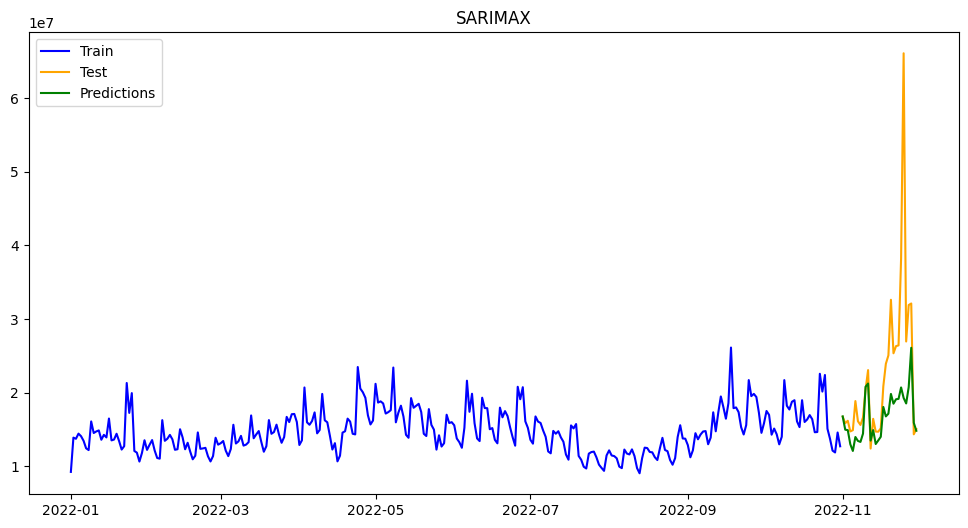

RMSE: 10394546.21
MAE: 5716466.26
MAPE: 19.36%


In [ ]:
model_assessment(train['y']['2022'], test['y']['2022'], predictions_sarimax, chart_title='SARIMAX')

### Cros Validation

In [ ]:
# Define the model to do CV
model_cv = ARIMA(order=(2,1,2),
                 seasonal_order=(2,0,2,7))

In [ ]:
# Set the CV rules
from pmdarima import model_selection
cv = model_selection.RollingForecastCV(h=30,
                                       step=15,
                                       initial = df.shape[0]-180)

In [ ]:
# Inputs for the CV
cv_score = model_selection.cross_val_score(model_cv,
                                           df['revenue'],
                                           cv=cv,
                                           scoring='mean_squared_error',
                                           verbose=1,
                                           error_score=100000000000000000000000000000000)

In [ ]:
np.sqrt(np.average(cv_score))

4985640.267023635

### Parameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [ ]:
# Defining the parameters
param_grid = {
    'p': [1, 2, 3],
    'd': [0, 1],
    'q': [1, 2, 3],
    'P': [1, 2],
    'D': [0],
    'Q': [1, 2]
}

grid = ParameterGrid(param_grid)
len(list(grid))

72

In [ ]:
# Parameter Tuning loop
rmse_list = []

# Evaluate the model
cv = model_selection.RollingForecastCV(h=30,
                                      step=15,
                                      initial = df.shape[0]-180)

for params in grid:
  try:
    model_cv = ARIMA(order = (params['p'], params['d'], params['q']),
                     seasonal_order = (params['P'], params['D'], params['Q'], 7))

    cv_score = model_selection.cross_val_score(model_cv,
                                              df['y'],
                                              cv=cv,
                                              scoring='mean_squared_error',
                                              verbose=1,
                                              error_score=100000000000000000000000000000000)
    # Store the error
    rmse =np.sqrt(np.average(cv_score))
    rmse_list.append(rmse)
  except:
    print(f"Tổ hợp {params} bị lỗi !")

Tổ hợp {'D': 0, 'P': 1, 'Q': 2, 'd': 0, 'p': 2, 'q': 1} bị lỗi !


In [ ]:
# Checking the results
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse_list
tuning_results.sort_values(by='rmse', ascending=True)

[]

In [ ]:
# Save the best parameters
tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()]